# Metadata Bayesian Reduction Model for *Listeria monocytogenes*

In [1]:
%matplotlib inline

import random
import math
import matplotlib.pyplot as plt
from copy import deepcopy
import numpy as np
import pystan 
import pandas as pd
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from tqdm.notebook import tqdm as tqdm
import matplotlib.colors as mc
import colorsys
import collections

def lighten_color(color, amount=0.5):  
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


In [2]:
datum = pd.read_csv('../../data/Metadata/all_lis_reduction.csv')
data_milk = datum[datum["Product"]=="Milk"]

In [3]:
data_milk = data_milk[(data_milk["pH"]==7)|np.isnan(data_milk["pH"])]
data_milk

,Microorganism,Species,Strain,Product group,Product,Treatment,aw,pH,T,D,...,log D model dairy,log D model milk,log D model meat,log D model beef,log D model chicken,Unnamed: 22,F-test,logD (all),logD (10% NaCl),logD (rest)
54,Listeria,monocytogenes,F5069,Dairy,Milk,11% nonfat milk solids,NaN,NaN,62.7,0.900000,...,-0.1148,-0.13271,NaN,NaN,NaN,NaN,NaN,0.011287,NaN,-0.027140
57,Listeria,monocytogenes,Scott A,Dairy,Milk,formulated,NaN,7.0,55.0,77.500000,...,1.0941,1.10160,NaN,NaN,NaN,NaN,NaN,1.074470,NaN,1.066185
60,Listeria,monocytogenes,Scott A,Dairy,Milk,formulated,NaN,7.0,60.0,2.975000,...,0.3091,0.30010,NaN,NaN,NaN,NaN,NaN,0.384092,NaN,0.356233
63,Listeria,monocytogenes,Scott A,Dairy,Milk,formulated,NaN,7.0,65.0,0.400000,...,-0.4759,-0.50140,NaN,NaN,NaN,NaN,NaN,-0.306287,NaN,-0.353718
66,Listeria,monocytogenes,Scott A,Dairy,Milk,formulated (+ milkfat (2.5%)),NaN,7.0,55.0,82.000000,...,1.0941,1.10160,NaN,NaN,NaN,NaN,NaN,1.074470,NaN,1.066185
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,Listeria,monocytogenes,NaN,Dairy,Milk,"whole, sterile",NaN,NaN,71.7,0.050000,...,-1.5278,-1.57541,NaN,NaN,NaN,NaN,NaN,-1.231395,NaN,-1.305053
276,Listeria,monocytogenes,NaN,Dairy,Milk,"whole, sterile",NaN,NaN,71.7,0.076667,...,-1.5278,-1.57541,NaN,NaN,NaN,NaN,NaN,-1.231395,NaN,-1.305053
277,Listeria,monocytogenes,NaN,Dairy,Milk,"whole, sterile",NaN,NaN,74.4,0.025000,...,-1.9517,-2.00822,NaN,NaN,NaN,NaN,NaN,-1.604199,NaN,-1.688426
278,Listeria,monocytogenes,NaN,Dairy,Milk,"whole, sterile",NaN,NaN,74.4,0.018333,...,-1.9517,-2.00822,NaN,NaN,NaN,NaN,NaN,-1.604199,NaN,-1.688426


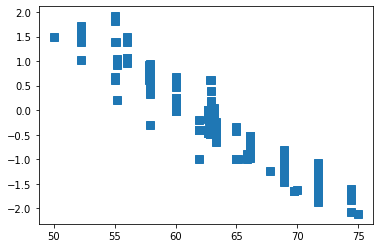

In [4]:
plt.plot(data_milk['T'],
         np.log10(data_milk['D']), marker="s", linestyle="none", markersize=8)

In [5]:
collections.Counter(data_milk["Strain"])

Counter({'F5069': 36,
         'Scott A': 23,
         nan: 75,
         'F5027': 3,
         '19115': 2,
         'V7': 6,
         'California': 2,
         '19113': 1,
         '19111': 1,
         'NCTC 98635S': 9,
         'NCTC 98635R': 9,
         'NCTC 11994S': 9,
         'NCTC 11994R': 9,
         'V7; F6861': 8,
         'BS-9': 6,
         'SE-31': 6,
         'ATCC 19111': 1,
         'ATCC 19113': 1,
         'ATCC 19115': 1})

In [6]:
np.mean(data_milk['T'])

62.33197115384615

In [7]:
np.mean(data_milk["T"])

62.33197115384615

In [8]:
T_ref = np.mean(data_milk["T"])
print(T_ref)

62.33197115384615


In [9]:
sm_metadata_D = pickle.load(open('stan_model_D.pkl', 'rb'))


fit_nuts_metadata_D = sm_metadata_D.sampling(
    data=dict(D = data_milk["D"], 
              T = data_milk["T"], 
              T_ref = T_ref,
              N = len(data_milk["T"])), 
    iter=30000, chains=4, thin=1, warmup=5000, seed=1234, 
    control = dict(adapt_delta = 0.80, max_treedepth=10)
    )


with open('fit_nuts_metadata_D.pkl', 'wb') as g:
    pickle.dump(fit_nuts_metadata_D, g)


print(fit_nuts_metadata_D)


Gradient evaluation took 7.5e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.75 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 6.6e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.66 seconds.
Adjust your expectations accordingly!



Iteration:     1 / 30000 [  0%]  (Warmup)

Gradient evaluation took 6.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.61 seconds.
Adjust your expectations accordingly!


Gradient evaluation took 6.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.69 seconds.
Adjust your expectations accordingly!


Iteration:     1 / 30000 [  0%]  (Warmup)
Iteration:     1 / 30000 [  0%]  (Warmup)
Iteration:     1 / 30000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter is -inf, but must be finite!  (in 'unknown file name' at line 31)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter is -inf, but must be finite!  (in 'unknown file name' at line 31)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be reject

Iteration:  3000 / 30000 [ 10%]  (Warmup)
Iteration:  3000 / 30000 [ 10%]  (Warmup)
Iteration:  3000 / 30000 [ 10%]  (Warmup)
Iteration:  3000 / 30000 [ 10%]  (Warmup)
Iteration:  5001 / 30000 [ 16%]  (Sampling)
Iteration:  5001 / 30000 [ 16%]  (Sampling)
Iteration:  5001 / 30000 [ 16%]  (Sampling)
Iteration:  5001 / 30000 [ 16%]  (Sampling)
Iteration:  8000 / 30000 [ 26%]  (Sampling)
Iteration:  8000 / 30000 [ 26%]  (Sampling)
Iteration:  8000 / 30000 [ 26%]  (Sampling)
Iteration:  8000 / 30000 [ 26%]  (Sampling)
Iteration: 11000 / 30000 [ 36%]  (Sampling)
Iteration: 11000 / 30000 [ 36%]  (Sampling)
Iteration: 14000 / 30000 [ 46%]  (Sampling)
Iteration: 14000 / 30000 [ 46%]  (Sampling)
Iteration: 11000 / 30000 [ 36%]  (Sampling)
Iteration: 11000 / 30000 [ 36%]  (Sampling)
Iteration: 17000 / 30000 [ 56%]  (Sampling)
Iteration: 17000 / 30000 [ 56%]  (Sampling)
Iteration: 14000 / 30000 [ 46%]  (Sampling)
Iteration: 20000 / 30000 [ 66%]  (Sampling)
Iteration: 14000 / 30000 [ 46%]  (Sampli

/opt/anaconda3/envs/pystan/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  from ipykernel import kernelapp as app


Inference for Stan model: anon_model_3e02c8fb38d1511d5bbb882e11447869.
4 chains, each with iter=30000; warmup=5000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=100000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
z                6.37  4.7e-4   0.14    6.1   6.28   6.37   6.47   6.67  93541    1.0
D_ref            0.81  1.2e-4   0.04   0.74   0.79   0.81   0.84   0.89  96685    1.0
s_logD           0.29  4.7e-5   0.01   0.26   0.28   0.29    0.3   0.32  94031    1.0
logD_pred[1]    -0.15  6.5e-5   0.02  -0.19  -0.16  -0.15  -0.14  -0.11  96598    1.0
logD_pred[2]     1.06  1.1e-4   0.03    1.0   1.04   1.06   1.08   1.12  95937    1.0
logD_pred[3]     0.27  7.0e-5   0.02   0.23   0.26   0.27   0.29   0.32  96774    1.0
logD_pred[4]    -0.51  7.2e-5   0.02  -0.55  -0.52  -0.51  -0.49  -0.47  95939    1.0
logD_pred[5]     1.06  1.1e-4   0.03    1.0   1.04   1.06   1.08   1.12  95937    1.0
logD_pred[6]     0.27  7.0e-5   0

Progress:   0%|          | 0/300 [00:00<?, ?it/s]

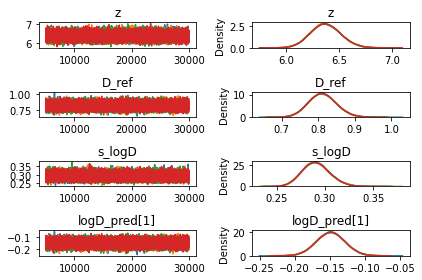

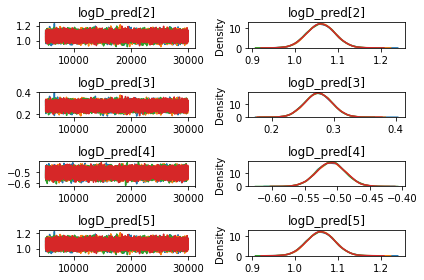

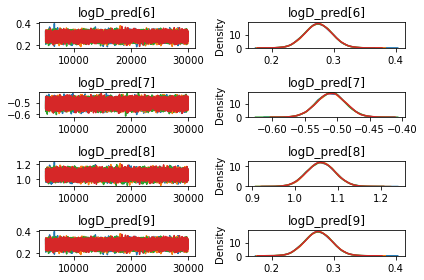

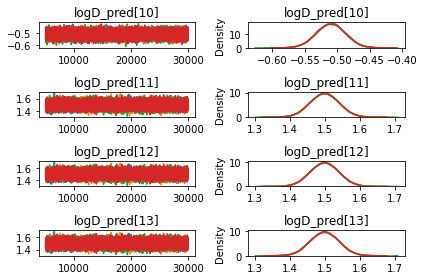

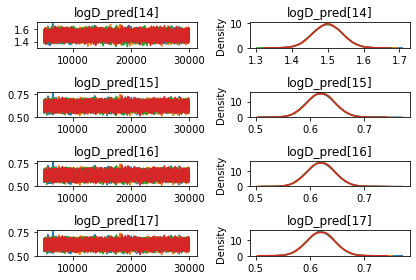

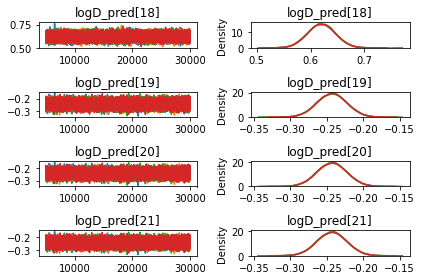

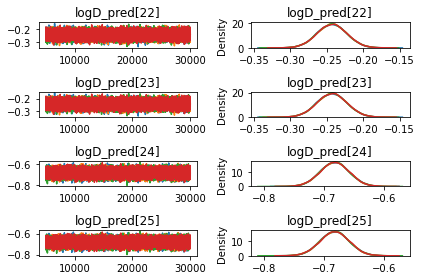

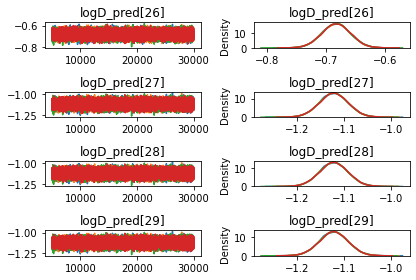

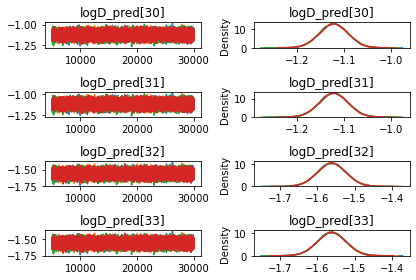

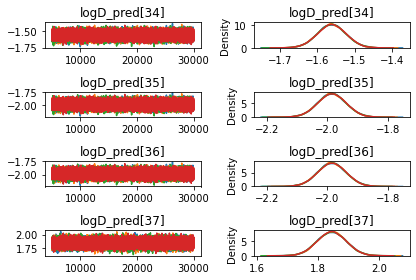

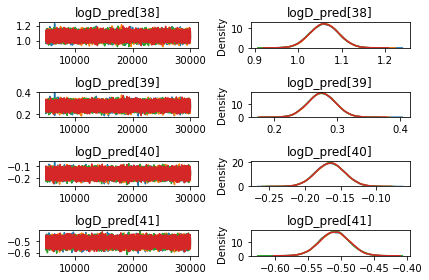

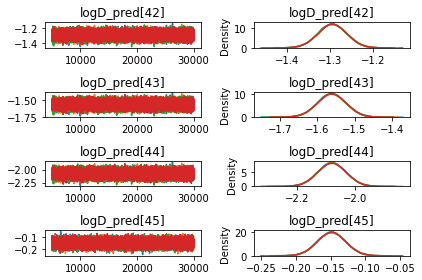

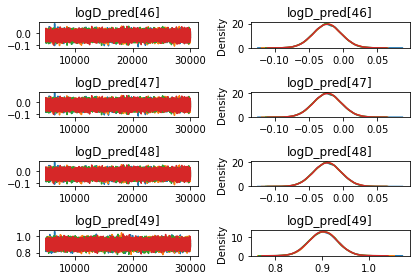

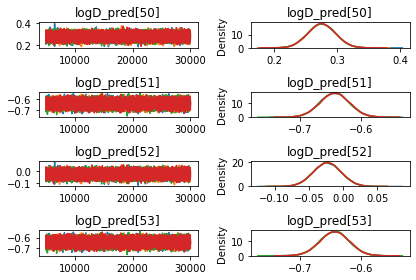

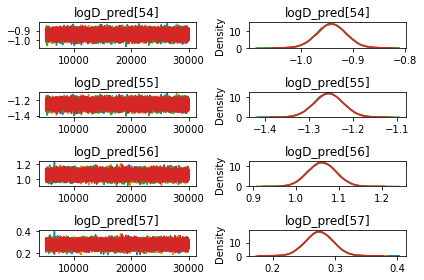

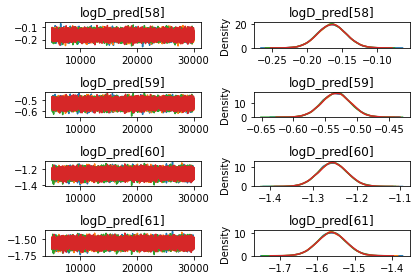

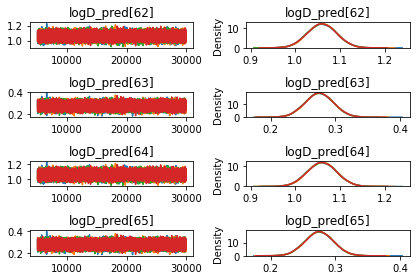

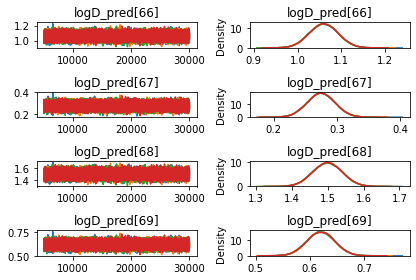

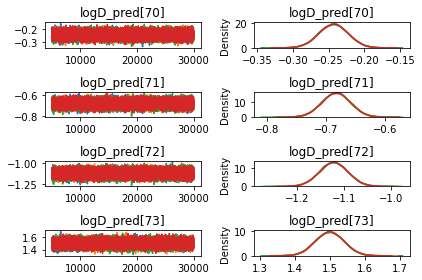

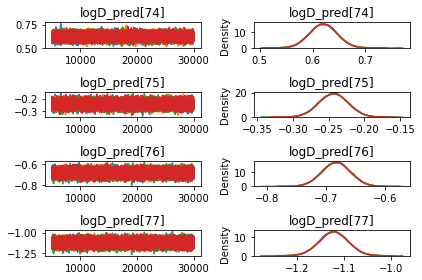

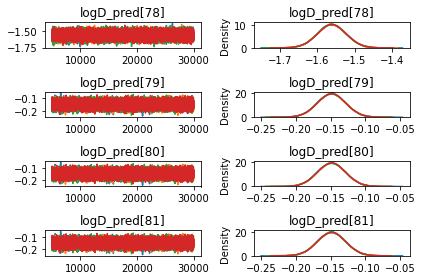

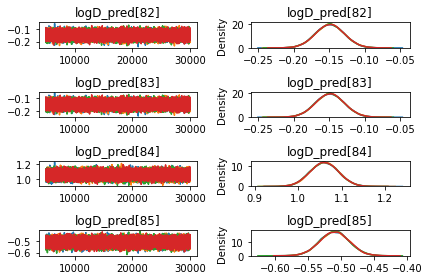

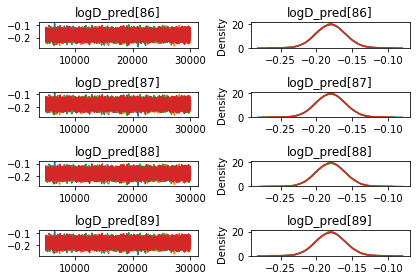

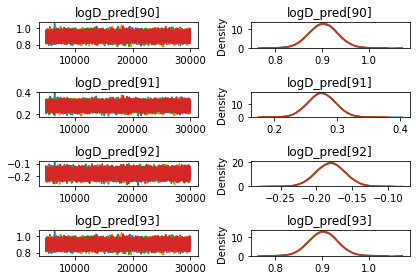

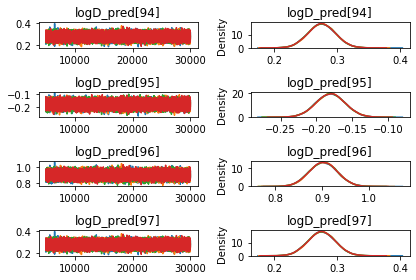

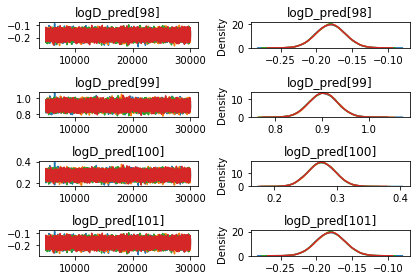

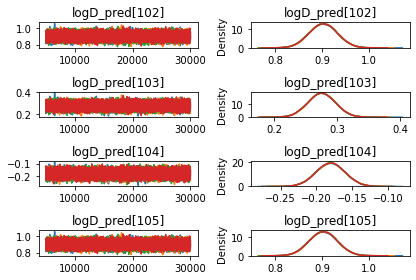

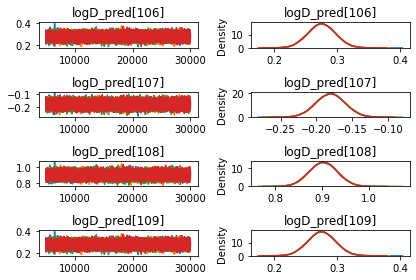

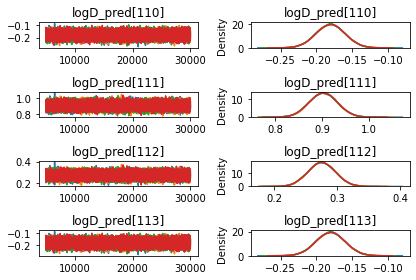

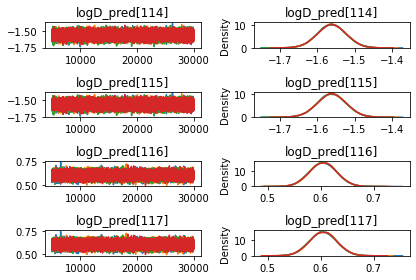

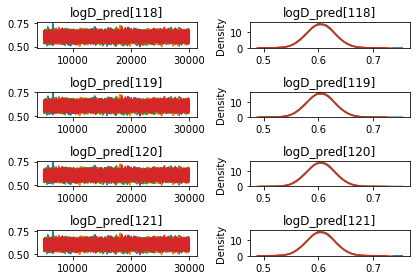

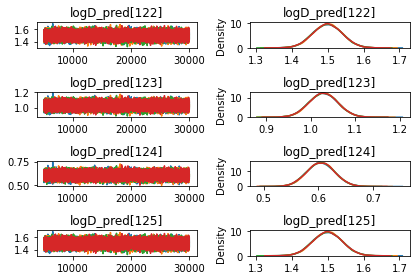

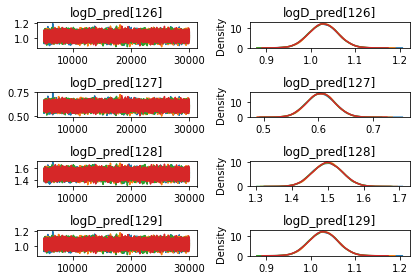

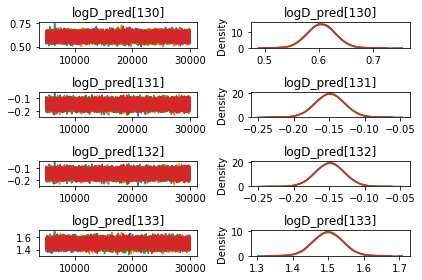

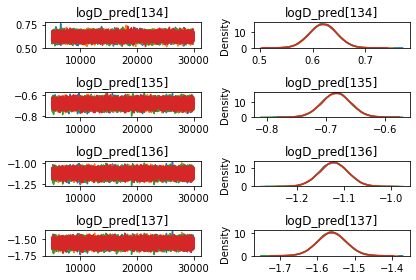

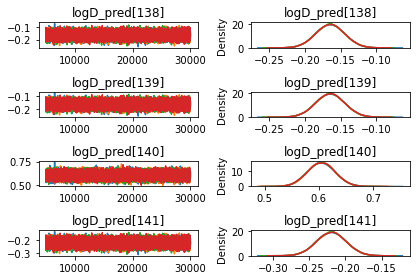

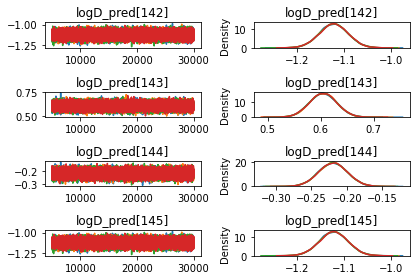

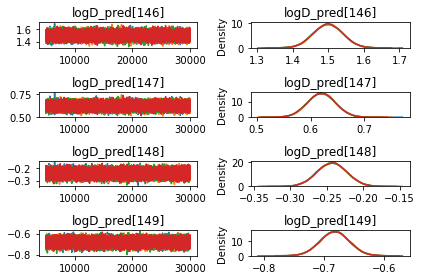

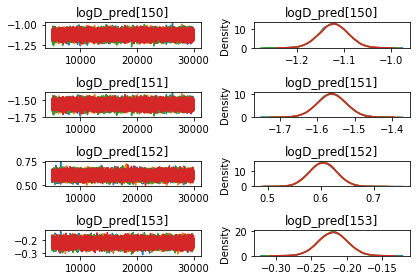

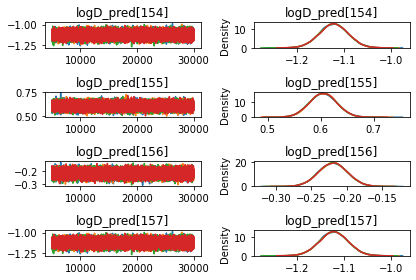

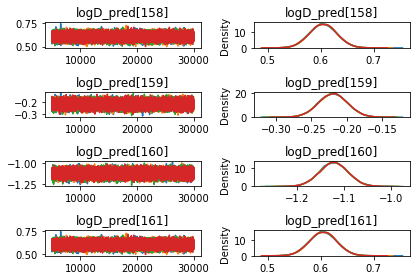

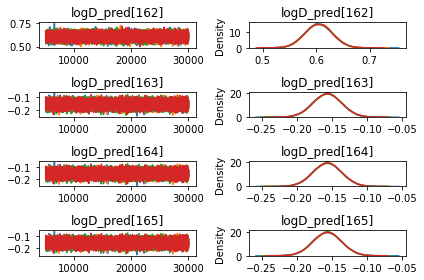

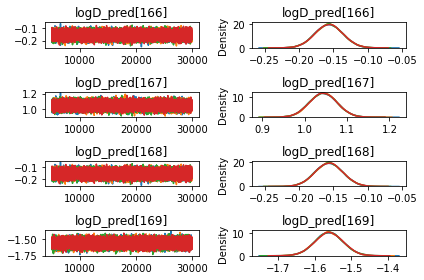

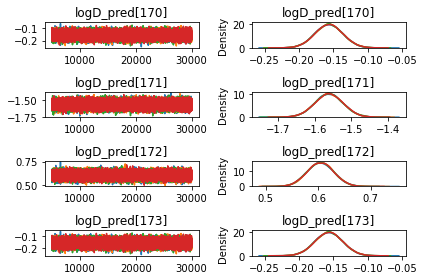

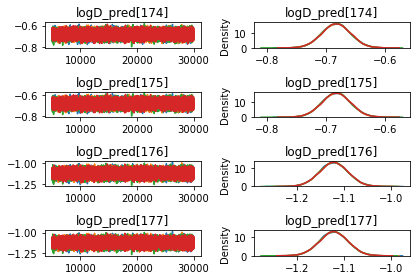

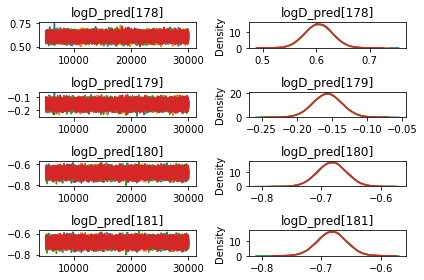

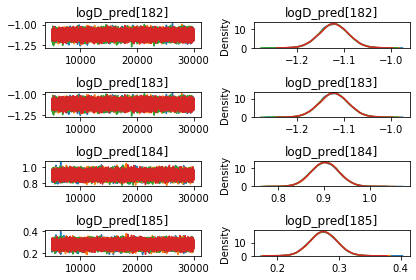

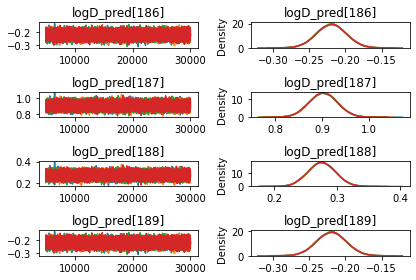

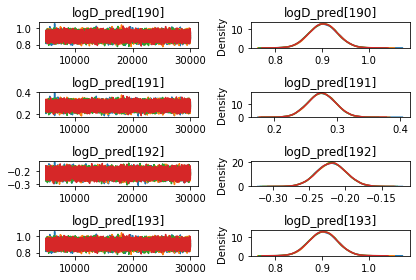

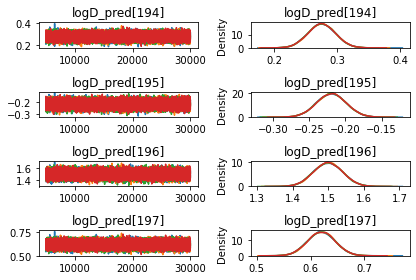

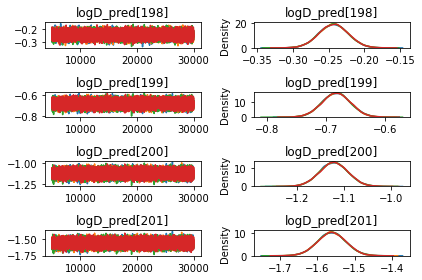

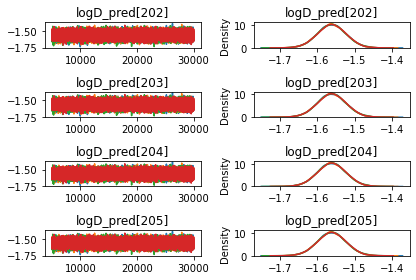

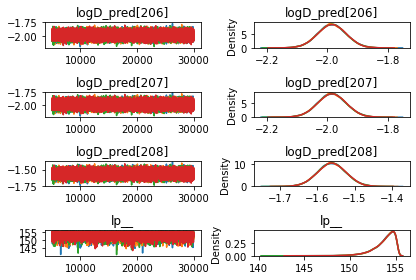

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [10]:
samples = fit_nuts_metadata_D.extract(permuted=False, inc_warmup=True)
paraname = fit_nuts_metadata_D.sim["fnames_oi"]
palette = sns.color_palette()
ms = fit_nuts_metadata_D.extract(permuted=False, inc_warmup=True)
iter_from = fit_nuts_metadata_D.sim['warmup']
iter_range = np.arange(iter_from, ms.shape[0])
paraname = fit_nuts_metadata_D.sim['fnames_oi']
num_pages = math.ceil(len(paraname)/4)
for pg in tqdm(range(300),desc='Progress', leave=False):
    plt.figure()
    
    for pos in range(4):
        pi = pg*4 + pos
        if pi >= len(paraname): break
        plt.subplot(4, 2, 2*pos+1)
        plt.tight_layout()
        [plt.plot(iter_range + 1, ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
        plt.subplot(4, 2, 2*(pos+1))
        plt.tight_layout()
        [sns.kdeplot(ms[iter_range,ci,pi], color=palette[ci]) for ci in range(ms.shape[1])]
        plt.title(paraname[pi])
    
    plt.show()

In [11]:
Temp_EA_MZ=[45,50,55,60,65,70,72,75,80,85,90,95,100,105,110,115,120,125,130,135,140,145]
logD_mean_EA_MZ=[2.7046,1.9031,1.1016,0.3001,-0.5014,-1.3029,-1.6235,-2.1044,-2.9059,-3.7074,-4.5089,-5.3104,-6.1119,-6.9134,-7.7149,-8.5164,-9.3179,-10.1194,-10.9209,-11.7224,-12.5239,-13.3254]
logD_95_EA_MZ=[3.286119857,2.484619857,1.683119857,0.881619857,0.080119857,-0.721380143,-1.041980143,-1.522880143,-2.324380143,-3.125880143,-3.927380143,-4.728880143,-5.530380143,-6.331880143,-7.133380143,-7.934880143,-8.736380143,-9.537880143,-10.33938014,-11.14088014,-11.94238014,-12.74388014]

In [12]:
T_ref = np.mean(data_milk["T"])
def Fit_Model(T, z, T_ref, D_ref) :
    return -1*(T-T_ref) /z + np.log10(D_ref)
samples = fit_nuts_metadata_D.extract(permuted=True)
temp_min = 50 
temp_max = 95
devide = (temp_max-temp_min)*10
temp_interval = np.arange(temp_min, temp_max*(devide+1)/devide, 
                          (temp_max-temp_min)/devide, dtype="float")
Num_mcmc = len(samples["lp__"])
logD_conf_mcmc = np.zeros((len(temp_interval),Num_mcmc), dtype=float)
logD_conf_mcmc_quantile = np.zeros((len(temp_interval), 3), dtype=float)
logD_predict_mcmc = np.zeros((len(temp_interval),Num_mcmc), dtype=float)
logD_predict_mcmc_quantile = np.zeros((len(temp_interval), 3), dtype=float)
for j in tqdm(range(len(temp_interval)),desc='Progress', leave=False):
    for k in range(Num_mcmc):
        logD_conf_mcmc[j,k] = Fit_Model(temp_interval[j], samples["z"][k], np.mean(data_milk["T"]), samples["D_ref"][k])
        logD_predict_mcmc[j,k] = np.random.normal(Fit_Model(temp_interval[j], 
                                                            samples["z"][k],
                                                            np.mean(data_milk["T"]),
                                                            samples["D_ref"][k]),
                                                  samples["s_logD"][k])

    logD_conf_mcmc_quantile[j,:] = np.quantile(logD_conf_mcmc[j,:],[0.025,  0.5, 0.975])
    logD_predict_mcmc_quantile[j,:] = np.quantile(logD_predict_mcmc[j,:],[0.025,  0.5, 0.975])

Progress:   0%|          | 0/453 [00:00<?, ?it/s]

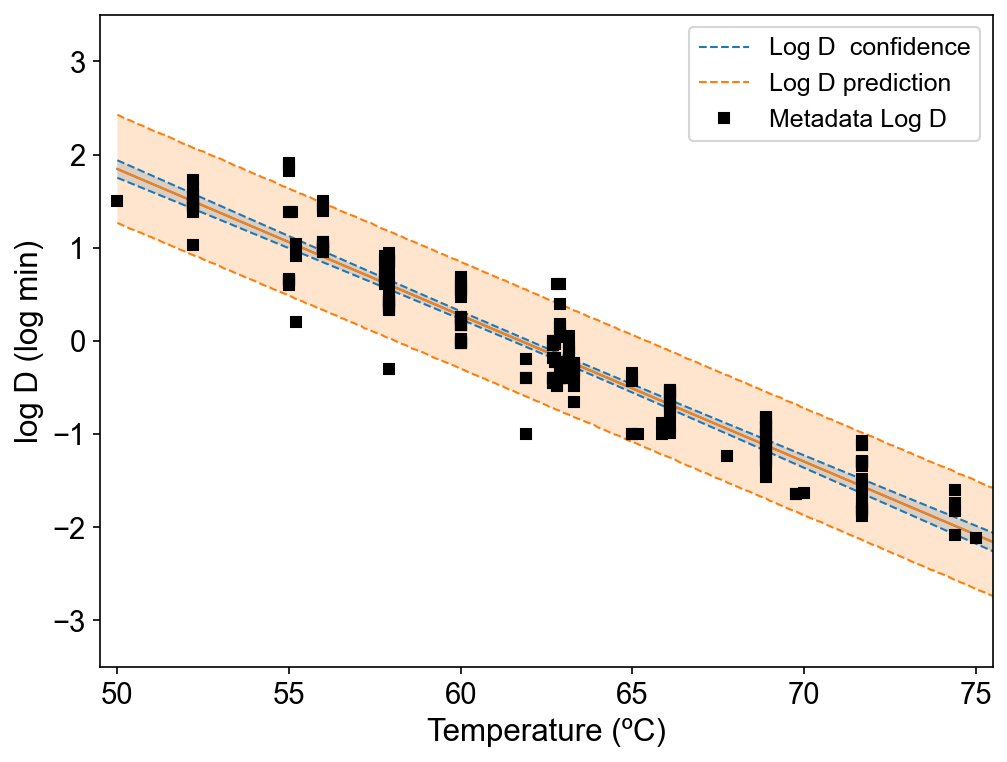

In [13]:
pdf = PdfPages("Fig. S1a.pdf")
plt.figure(figsize=[6.4*1.2, 4.8*1.2], dpi=150)
plt.rcParams["font.family"] = "Arial"

plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel("Temperature (ºC)",size=15,fontname="Arial")
plt.ylabel("log D (log min)",size=15,fontname="Arial")
plt.xticks(np.arange(50, 76, 5))
plt.ylim([-3.5,3.5])
plt.xlim([49.5,75.5])

Palette=sns.color_palette(n_colors = 3)
plt.fill_between(temp_interval, logD_conf_mcmc_quantile[:,0], logD_conf_mcmc_quantile[:,2], facecolor=Palette[0], alpha=0.2)
plt.plot(temp_interval, logD_conf_mcmc_quantile[:,0], lw=1, color=Palette[0], linestyle='--')
plt.plot(temp_interval, logD_conf_mcmc_quantile[:,2], lw=1, color=Palette[0], linestyle='--', label="Log D  confidence")
plt.plot(temp_interval, logD_conf_mcmc_quantile[:,1], lw=1, color=Palette[0])

plt.fill_between(temp_interval, logD_predict_mcmc_quantile[:,0], logD_predict_mcmc_quantile[:,2], facecolor=Palette[1], alpha=0.2)
plt.plot(temp_interval, logD_predict_mcmc_quantile[:,0], lw=1, color=Palette[1], linestyle='--')
plt.plot(temp_interval, logD_predict_mcmc_quantile[:,2], lw=1, color=Palette[1], linestyle='--', label="Log D prediction")
plt.plot(temp_interval, logD_predict_mcmc_quantile[:,1], lw=1, color=Palette[1])


#plt.plot(Temp_EA_MZ, logD_95_EA_MZ, lw=1, color="black", linestyle='--')
#plt.plot(Temp_EA_MZ, logD_mean_EA_MZ, lw=1, color="black", label="MZ prediction")


plt.plot(data_milk["T"], np.log10(data_milk["D"]), marker='s', ms=5,color="black", lw=0, label="Metadata Log D")
plt.legend(fontsize=12)


pdf.savefig()
pdf.close()
plt.show()

In [14]:
logD_mean = np.zeros((len(temp_interval), 2), dtype=float)
logD_mean[:,0] = temp_interval
logD_mean[:,1] = logD_predict_mcmc_quantile[:,1]

with open('LogD mean.pkl', 'wb') as g:
    pickle.dump(logD_mean, g)
